In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

In [2]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

In [3]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [4]:
kospi200 = pd.read_csv("./data/data.csv", encoding="cp949")
kospi200 = kospi200[kospi200.columns[:2]]
kospi200["종목코드"] = kospi200["종목코드"].map('{:06d}'.format)
kospi200.head()

,종목코드,종목명
0,006840,AK홀딩스
1,027410,BGF
2,282330,BGF리테일
3,138930,BNK금융지주
4,001040,CJ


In [5]:
code_dict = { i : j for i, j in zip(kospi200["종목명"], kospi200["종목코드"]) }

In [6]:
import pickle

with open('raw_data_20180811.pickle', 'rb') as handle:
    raw_data = pickle.load(handle)

In [7]:
test_dict = {1:1,2:2,3:3}
del test_dict[1]

In [8]:
test_dict

{2: 2, 3: 3}

In [9]:
del_list = []
for key, df in raw_data.items():
    if len(df) < 800:
        del_list.append(key)
for code in del_list:
    del raw_data[code]
    print("{}는 지워졌습니다.".format(code))

282330는 지워졌습니다.
294870는 지워졌습니다.
079550는 지워졌습니다.
285130는 지워졌습니다.
251270는 지워졌습니다.
241560는 지워졌습니다.
207940는 지워졌습니다.
271560는 지워졌습니다.
214320는 지워졌습니다.
267250는 지워졌습니다.
298040는 지워졌습니다.


In [10]:
raw_data["005930"].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-02,21400.0,21600.0,21300.0,21600.0,21.233131,13151350
2012-01-03,21860.0,22100.0,21840.0,22100.0,21.724644,16927750
2012-01-04,22100.0,22200.0,21500.0,21600.0,21.233131,17103700
2012-01-05,21460.0,21580.0,21100.0,21100.0,20.741627,17298400
2012-01-06,21120.0,21320.0,20600.0,20800.0,20.446722,18816250


In [11]:
from sklearn.preprocessing import MinMaxScaler
import sys
mod = sys.modules[__name__]
minmax = MinMaxScaler()
for i in raw_data.keys():
    raw_data[i] = raw_data[i].assign(pct_change = raw_data[i].Close.pct_change().fillna(0))
    for j in [5,10,15,20,25]:
        raw_data[i]["close_ma_{}".format(j)] = raw_data[i].Close.rolling(j).mean()
        raw_data[i]["close_ma_{}".format(j)] = raw_data[i]["close_ma_{}".format(j)].fillna(method = "bfill")
        raw_data[i]["vol_ma_{}".format(j)] = raw_data[i].Volume.rolling(j).mean()
        raw_data[i]["vol_ma_{}".format(j)] = raw_data[i]["vol_ma_{}".format(j)].fillna(method = "bfill")
    raw_data[i]["minmax_vol"] = minmax.fit_transform(raw_data[i].Volume.values.reshape(-1,1))
    raw_data[i]["minmax_close"] = (raw_data[i].Close - raw_data[i].Low)/(raw_data[i].High - raw_data[i].Low)
    raw_data[i]["minmax_vol"] = raw_data[i]["minmax_vol"].fillna(raw_data[i]["minmax_vol"].mean())
    raw_data[i]["minmax_close"] = raw_data[i]["minmax_close"].fillna(raw_data[i]["minmax_close"].mean())

C:\Users\JinMyungHun\Anaconda3\envs\ds\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [66]:
t = raw_data["005930"]["pct_change"].rolling(5).mean().copy()
t.index = range(len(t))
test = raw_data["005930"]["pct_change"].rolling(5).mean().copy()
test.iloc[:-1] = t.iloc[1:].values

In [73]:
pd.concat((test, raw_data["005930"]["pct_change"].rolling(5).mean()), axis=1).head()

,pct_change,pct_change
Date,,
2012-01-02,NaN,NaN
2012-01-03,NaN,NaN
2012-01-04,NaN,NaN
2012-01-05,-0.007368,NaN
2012-01-06,-0.011984,-0.007368


In [12]:
for code in raw_data.keys():
    pct_ma = raw_data[code]["pct_change"].rolling(5).mean().fillna(method="bfill")
    t = raw_data[code]["pct_change"].rolling(5).mean().copy()
    t.index = range(len(t))
    pct_ma_minus_1 = raw_data[code]["pct_change"].rolling(5).mean().copy()
    pct_ma_minus_1.iloc[:-1] = t.iloc[1:].values
    raw_data[code]["Y"] = np.where(pct_ma < pct_ma_minus_1, 1, 0)

In [13]:
raw_data["005930"].head()

,Open,High,Low,Close,Adj Close,Volume,pct_change,close_ma_5,vol_ma_5,close_ma_10,vol_ma_10,close_ma_15,vol_ma_15,close_ma_20,vol_ma_20,close_ma_25,vol_ma_25,minmax_vol,minmax_close,Y
Date,,,,,,,,,,,,,,,,,,,,
2012-01-02,21400.0,21600.0,21300.0,21600.0,21.233131,13151350,0.000000,21440.0,16659490.0,20994.0,17524715.0,21026.666667,1.781618e+07,21344.0,17923810.0,21388.8,17971574.0,0.203325,1.000000,0
2012-01-03,21860.0,22100.0,21840.0,22100.0,21.724644,16927750,0.023148,21440.0,16659490.0,20994.0,17524715.0,21026.666667,1.781618e+07,21344.0,17923810.0,21388.8,17971574.0,0.261710,1.000000,0
2012-01-04,22100.0,22200.0,21500.0,21600.0,21.233131,17103700,-0.022624,21440.0,16659490.0,20994.0,17524715.0,21026.666667,1.781618e+07,21344.0,17923810.0,21388.8,17971574.0,0.264430,0.142857,0
2012-01-05,21460.0,21580.0,21100.0,21100.0,20.741627,17298400,-0.023148,21440.0,16659490.0,20994.0,17524715.0,21026.666667,1.781618e+07,21344.0,17923810.0,21388.8,17971574.0,0.267441,0.000000,0
2012-01-06,21120.0,21320.0,20600.0,20800.0,20.446722,18816250,-0.014218,21440.0,16659490.0,20994.0,17524715.0,21026.666667,1.781618e+07,21344.0,17923810.0,21388.8,17971574.0,0.290907,0.277778,0


In [14]:
for i in raw_data.keys():
    print("{} : {}".format(i, sum(raw_data[i].Y==1)/len(raw_data[i])))

006840 : 0.5030864197530864
027410 : 0.4743465634075508
138930 : 0.48703703703703705
001040 : 0.4888888888888889
079160 : 0.49753086419753084
000120 : 0.49320987654320986
097950 : 0.5080246913580246
005830 : 0.4882716049382716
000990 : 0.49135802469135803
114090 : 0.4993827160493827
078930 : 0.49753086419753084
006360 : 0.504320987654321
007070 : 0.5024691358024691
012630 : 0.4839506172839506
001060 : 0.5074074074074074
096760 : 0.5104938271604939
105560 : 0.49506172839506174
002380 : 0.5061728395061729
030200 : 0.4858024691358025
033780 : 0.49074074074074076
093050 : 0.4925925925925926
003550 : 0.5012345679012346
034220 : 0.5067901234567901
001120 : 0.49753086419753084
051900 : 0.4901234567901235
032640 : 0.4888888888888889
011070 : 0.49382716049382713
066570 : 0.4901234567901235
108670 : 0.48148148148148145
051910 : 0.49876543209876545
006260 : 0.49876543209876545
010120 : 0.49074074074074076
035420 : 0.495679012345679
005940 : 0.49444444444444446
010060 : 0.4993827160493827
005490 :

In [87]:
import itertools

pool = ['A', 'B', 'C']
print(list(map(''.join, itertools.permutations(pool)))) # 3개의 원소로 수열 만들기
print(list(map(''.join, itertools.permutations(pool, 2)))) # 2개의 원소로 수열 만들기

['ABC', 'ACB', 'BAC', 'BCA', 'CAB', 'CBA']
['AB', 'AC', 'BA', 'BC', 'CA', 'CB']


In [16]:
train_idx = {}
test_idx = {}
for i in [5,10,15,20,25]:
    setattr(mod, "train_{}".format(i), {})
    setattr(mod, "test_{}".format(i), {})
    for j in [5,10,15,20,25]:
        if i<j:
            setattr(mod, "train_{}_{}".format(i,j), {})
            setattr(mod, "test_{}_{}".format(i,j), {})
            for code, df in raw_data.items():
                getattr(mod, "train_{}_{}".format(i,j))[code] = \
                    df.iloc[:int(len(df)*0.8)][["close_ma_{}".format(i), "close_ma_{}".format(j), "minmax_close", "minmax_vol"]]
                getattr(mod, "test_{}_{}".format(i,j))[code] = \
                    df.iloc[int(len(df)*0.8):][["close_ma_{}".format(i), "close_ma_{}".format(j), "minmax_close", "minmax_vol"]]
        elif i>j:
            continue
        else:
            for code, df in raw_data.items():
                getattr(mod, "train_{}".format(i))[code] = \
                    df.iloc[:int(len(df)*0.8)][["close_ma_{}".format(i), "minmax_close", "minmax_vol"]]
                getattr(mod, "test_{}".format(i))[code] = \
                    df.iloc[int(len(df)*0.8):][["close_ma_{}".format(i), "minmax_close", "minmax_vol"]]
                train_idx[code] = df.iloc[:int(len(df)*0.8)]["Y"]
                test_idx[code] = df.iloc[int(len(df)*0.8):]["Y"]

In [21]:
train_20_25["005930"].head()

,close_ma_20,close_ma_25,minmax_close,minmax_vol
Date,,,,
2012-01-02,21344.0,21388.8,1.000000,0.203325
2012-01-03,21344.0,21388.8,1.000000,0.261710
2012-01-04,21344.0,21388.8,0.142857,0.264430
2012-01-05,21344.0,21388.8,0.000000,0.267441
2012-01-06,21344.0,21388.8,0.277778,0.290907


Text(0.5,1,'삼성전자')

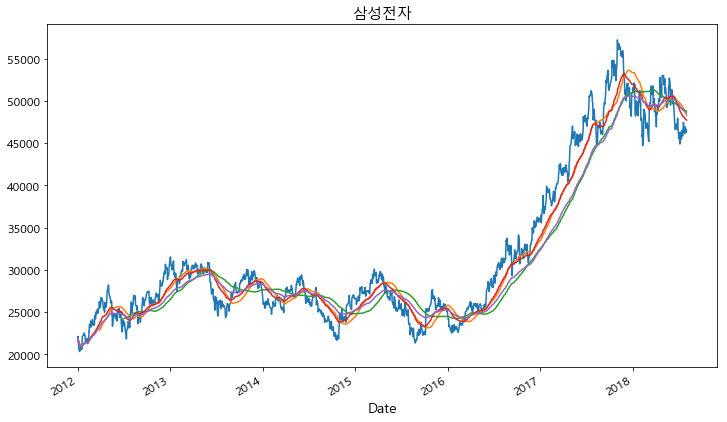

In [33]:
plt.figure(figsize=(12,7))
raw_data["005930"].Close.plot()
raw_data["005930"].Close.rolling(window=60).mean().plot()
raw_data["005930"].Close.rolling(window=120).mean().plot()
raw_data["005930"].Close.ewm(span=60).mean().plot()
raw_data["005930"].Close.ewm(span=120).mean().plot()
plt.title("삼성전자", fontsize=15)

In [ ]:
from functools import wraps
import time

def benchmarker(org_func):
    @wraps(org_func)
    def inner(*args, **kwargs):
        start = time.time() #epoch 1911.~ 시간을 정수형태 초단위로 반환
        result = org_func(*args, **kwargs)
        elapsed = time.time() - start
        print("elapsed time of {} : {}".format(org_func.__name__, round(elapsed, 6)))
        return result
    return inner